In [1]:
from importlib import reload
import functions
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
reload(functions)

<module 'functions' from 'c:\\Python64\\ADAML_GW\\adaml-ml-project\\functions.py'>

In [2]:
data_path = "household_power_consumption.txt"
df = functions.load_data(data_path)
df_hourly = functions.preprocess_data(df).reset_index()

In [3]:
#Add time variables: weekday, hour and day of year. Use sin/cosine transforms
df_hourly["hour_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.hour)/24)
df_hourly["hour_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.hour)/24)

df_hourly["weekday_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.weekday)/7)
df_hourly["weekday_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.weekday)/7)

df_hourly["day_of_year_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.day_of_year)/365)
df_hourly["day_of_year_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.day_of_year)/365)


In [4]:
class EnergyData(Dataset):
    def __init__(self, features, targets, window,horizon):
        self.features = features
        self.targets = targets
        self.window = window
        self.horizon = horizon
        
    def __getitem__(self, index):
        x = self.features[index:index+self.window]
        y = self.targets[(index+self.window):(index+self.window+self.horizon)]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features) - self.window - self.horizon

In [5]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1,device="cpu"):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = device
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=n_layers, batch_first=True) # RNN layer
        self.fc = nn.Linear(hidden_size, output_size) # output layer
        
    def forward(self, x):
        #print("Input shape:", x.shape)
        h0 = torch.zeros(self.n_layers, x.shape[0], self.hidden_size,device=self.device) # [num_layers, batch_size, hidden_size]
        output, _ = self.rnn(x, h0) # RNN forward pass
        output = self.fc(output[:, -1, :]) # use the last time step's output for classification
        return output
    

class RNNForecastModel(nn.Module):
    def __init__(self, n_features, hidden_size, output_size, n_layers=2,device="cpu"):
        super().__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.device = device
        self.encoder = nn.RNN(n_features, hidden_size, n_layers, batch_first=True,nonlinearity="tanh",dropout=0.2) #Encoder
        self.decoder = nn.RNN(1,hidden_size,n_layers, batch_first=True,nonlinearity="tanh",dropout=0.2) #Decoder
        self.fc = nn.Linear(hidden_size, 1) # output layer
        
    def forward(self, X):
        #Encoding
        _, h = self.encoder(X)
        decoder_input = torch.zeros(X.size(0),1,1,device=self.device)
        outputs  = []
        for i in range(self.output_size):
            out, h = self.decoder(decoder_input,h)
            y = self.fc(out)
            outputs.append(y)
            decoder_input = y
        return torch.cat(outputs,dim=1)

In [6]:
last_year = len(df_hourly) - 24*365

# Split data into training/validation and test sets, last year for testing
train_val_data = df_hourly.iloc[:last_year]
test_data = df_hourly.iloc[last_year:]


train_data,val_data = train_test_split(train_val_data,test_size=0.3,shuffle=False)

In [ ]:


#Lookback window and horizon
window = 72
horizon = 24

batch_size = 128


Y_train = train_data["Global_active_power"].values
X_train = train_data.iloc[:, 1:len(train_data.columns)].values

X_val = val_data.iloc[:, 1:len(val_data.columns)].values
Y_val = val_data["Global_active_power"].values


scalerX = MinMaxScaler()
scalerY = MinMaxScaler()

train_X = scalerX.fit_transform(X_train)
val_X = scalerX.transform(X_val)

train_Y = scalerY.fit_transform(Y_train.reshape(-1, 1))
val_Y = scalerY.transform(Y_val.reshape(-1, 1))

trainData = EnergyData(train_X, train_Y, window, horizon)
valData = EnergyData(val_X, val_Y, window, horizon)

trainLoader = DataLoader(trainData, batch_size=batch_size, shuffle=False)
valLoader = DataLoader(valData, batch_size=batch_size, shuffle=False)



Epoch 1 / 100, Training Loss: 0.0245, Validation Loss: 0.0190
Epoch 2 / 100, Training Loss: 0.0227, Validation Loss: 0.0174
Epoch 3 / 100, Training Loss: 0.0228, Validation Loss: 0.0166
Epoch 4 / 100, Training Loss: 0.0231, Validation Loss: 0.0164
Epoch 5 / 100, Training Loss: 0.0229, Validation Loss: 0.0163
Epoch 6 / 100, Training Loss: 0.0220, Validation Loss: 0.0154
Epoch 7 / 100, Training Loss: 0.0209, Validation Loss: 0.0146
Epoch 8 / 100, Training Loss: 0.0197, Validation Loss: 0.0137
Epoch 9 / 100, Training Loss: 0.0192, Validation Loss: 0.0136
Epoch 10 / 100, Training Loss: 0.0189, Validation Loss: 0.0137
Epoch 11 / 100, Training Loss: 0.0185, Validation Loss: 0.0139
Epoch 12 / 100, Training Loss: 0.0183, Validation Loss: 0.0139
Epoch 13 / 100, Training Loss: 0.0182, Validation Loss: 0.0139
Epoch 14 / 100, Training Loss: 0.0178, Validation Loss: 0.0141
Epoch 15 / 100, Training Loss: 0.0177, Validation Loss: 0.0144
Epoch 16 / 100, Training Loss: 0.0179, Validation Loss: 0.0139
E

In [ ]:
#Model initilization and training

input_size = 13 # number of features
hidden_size = 32
output_size = 24 # predicting a single value
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.MSELoss()
n_epochs = 150
learning_rate = 0.0005

model = RNNForecastModel(input_size, hidden_size, output_size,device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


model = model.to(device)

trainLosses = []
valLosses = []

model_path = "rnn_weights.pth"
min_validloss = np.inf

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in trainLoader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        pred=model(X_batch)
        loss=loss_fn(pred,y_batch)
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    preds = []
    truevalids = []
    with torch.inference_mode():
        val_loss = 0
        for X_batch, y_batch in valLoader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            val_loss += loss.item()
            preds.append(pred.detach().cpu().numpy())
            truevalids.append(y_batch.detach().cpu().numpy())

    print(f"Epoch {epoch+1} / {n_epochs}, Training Loss: {epoch_loss/len(trainLoader):.4f}, Validation Loss: {val_loss/len(valLoader):.4f}")
    trainLosses.append(epoch_loss/len(trainLoader))
    valLosses.append(val_loss/len(valLoader))
    if val_loss<min_validloss:
        min_validloss = val_loss
        torch.save(model.state_dict(),model_path)

# Lets store last epoch values...
preds_array = np.concatenate(preds, axis=0).flatten()
truevalids_array =  np.concatenate(truevalids, axis=0).flatten()

preds_real = scalerY.inverse_transform(preds_array.reshape(-1, 1))
truevalids_real = scalerY.inverse_transform(truevalids_array.reshape(-1, 1))




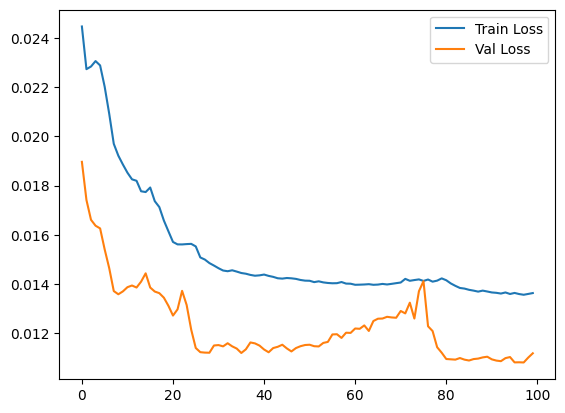

In [8]:
plt.figure()
plt.plot(trainLosses, label="Train Loss")
plt.plot(valLosses, label="Val Loss")
plt.legend()
plt.show()


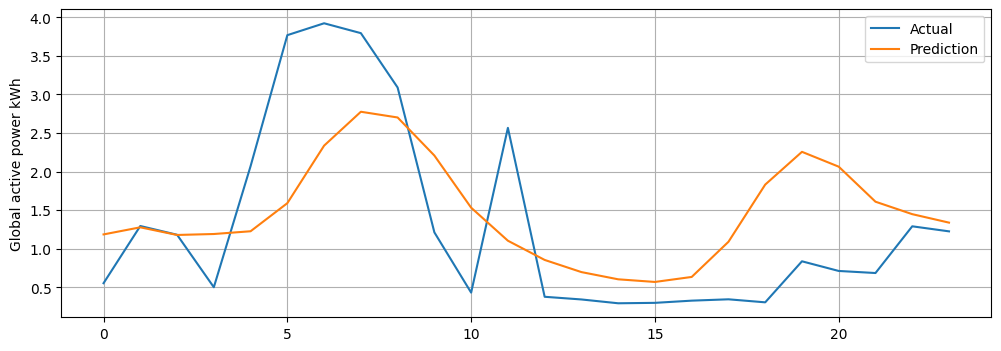

In [13]:
model = RNNForecastModel(input_size, hidden_size, output_size,device="cpu")
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()


X_torch, y_actual = valData.__getitem__(0)
y_actuals = y_actual.numpy()
with torch.no_grad():
    y_pred = model(X_torch.unsqueeze(0))
y_preds = y_pred.numpy()[0]
plt.figure(figsize=(12,4))
plt.plot(scalerY.inverse_transform(np.array(y_actuals).reshape(-1,1)),'-',label="Actual")
plt.plot(scalerY.inverse_transform(np.array(y_preds).reshape(-1,1)),label="Prediction")
plt.legend()
plt.grid()
plt.ylabel("Global active power kWh")
plt.show()

In [175]:

# input_size = X.shape[1] # number of features
# hidden_size = 64
# output_size = 1 # predicting a single value
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# loss_fn = nn.MSELoss()
# n_epochs = 50
# learning_rate = 0.001
# window = 24

# foldLosses = [[] for _ in range(nFolds)]
# trainLosses = [[] for _ in range(nFolds)]
# valLosses = [[] for _ in range(nFolds)]

# preds = []
# truevalids = []




# for i in range(len(folds)):
#     scalerX = StandardScaler()
#     scalerY = StandardScaler()

#     train_idx, val_idx = folds[i]
#     train_X, val_X = X.iloc[train_idx].values, X.iloc[val_idx].values
#     train_Y, val_Y = Y.iloc[train_idx].values, Y.iloc[val_idx].values

#     train_X = scalerX.fit_transform(train_X)
#     val_X = scalerX.transform(val_X)

#     train_Y = scalerY.fit_transform(train_Y.reshape(-1, 1))
#     val_Y = scalerY.transform(val_Y.reshape(-1, 1))

#     trainData = EnergyData(train_X, train_Y, window)
#     valData = EnergyData(val_X, val_Y, window)

#     trainLoader = DataLoader(trainData, batch_size=32, shuffle=True)
#     valLoader = DataLoader(valData, batch_size=32, shuffle=False)

#     model = RNNModel(input_size, hidden_size, output_size).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#     for epoch in range(n_epochs):
#         model.train()
#         epoch_loss = 0
#         for X_batch, y_batch in trainLoader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             # print("Batch X shape:", X_batch.shape)
#             # print("Batch y shape:", y_batch.shape)
#             #Prediction and loss
#             pred=model(X_batch)
#             # print("Prediction shape:", pred.shape)
#             # print("Prediction: ", pred)
#             loss=loss_fn(pred,y_batch)
#             epoch_loss += loss.item()
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # pred_real = scalerY.inverse_transform(pred.detach().cpu().numpy())
#             # y_real = scalerY.inverse_transform(y_batch.detach().cpu().numpy())
#             # print(pred_real, y_real)

#         model.eval()
#         with torch.inference_mode():
#             val_loss = 0
#             for X_batch, y_batch in valLoader:
#                 X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#                 pred = model(X_batch)
#                 loss = loss_fn(pred, y_batch)
#                 val_loss += loss.item()
#                 preds.append(pred.detach().cpu().numpy())
#                 truevalids.append(y_batch.detach().cpu().numpy())

#         print(f"Fold {i+1}, Epoch {epoch+1} / {n_epochs}, Training Loss: {epoch_loss/len(trainLoader):.4f}, Validation Loss: {val_loss/len(valLoader):.4f}")

#         trainLosses[i].append(epoch_loss/len(trainLoader))
#         valLosses[i].append(val_loss/len(valLoader))

#     foldLosses[i].append(val_loss/len(valLoader)) # last validation loss of the fold (not necessary but easy way :D)
    
#     #torch.save(model.state_dict(), f"models/rnn_fold_{i+1}.pth")
#     break # fold 1 test
